In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import squidpy as sq

/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/yufan.xia/tools/apps/mamba/envs/

In [2]:
import random

# For reproducibility
np.random.seed(42)
random.seed(42)

In [12]:
# adata_msi = sc.read("/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/V11L12-038_A1.MSI_MOSCOT_paired_hvg.h5ad")
# adata_msi = sc.read("/lustre/groups/ml01/workspace/eirini.giannakoulia/hand_prep/V11L12-038_A1.MSI_MOSCOT_paired_hvg_top20spatvar.h5ad")
# adata_rna = sc.read("/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/V11L12-038_A1.RNA_MOSCOT_paired_hvg.h5ad")

adata_msi = sc.read("/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/MSI_concat_neurotransmitters.h5ad")
adata_rna = sc.read("/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/RNA_concat_neurotransmitters.h5ad")

# adata_msi = sc.read("/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/MSI_concat_lipids.h5ad")
# adata_rna = sc.read("/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/RNA_concat_lipids.h5ad")


print(adata_msi)

AnnData object with n_obs × n_vars = 5443 × 1538
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'


/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [13]:
adata_msi.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
rows_with_nonzero = np.where(adata_msi.X.sum(axis=1) > 0)[0]
print("Rows with any non-zero values:", rows_with_nonzero)


Rows with any non-zero values: [   0    1    2 ... 5440 5441 5442]


In [15]:
total_nonzero = np.count_nonzero(adata_msi.X)
print(f"Total non-zero entries: {total_nonzero}, total entries:{adata_msi.X.shape[0]*adata_msi.X.shape[1]}")


Total non-zero entries: 2218963, total entries:8371334


In [16]:
cols_with_nonzero = np.sum(adata_msi.X > 0, axis=0) > 0
num_nonzero_columns = np.sum(cols_with_nonzero)

print(f"Number of columns with at least one non-zero value: {num_nonzero_columns}")


Number of columns with at least one non-zero value: 1538


In [66]:
adata_rna.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 611670 stored elements and shape (2681, 2000)>

### Set up binarization with percentiles and plot to get a feel for different cuttofs. 
This happens for each metabolite and not a universal cutoff


In [67]:
def binarize_by_percentile(adata, percentile=75, layer_name="binary"):
    """
    Binarizes metabolite abundances in an AnnData object by a given percentile threshold.
    
    Parameters
    ----------
    adata : AnnData
        AnnData object containing MSI/metabolite data in .X
    percentile : float
        The percentile above which a metabolite is considered 'existent'
    layer_name : str
        The name of the new layer to store the binarized data

    Returns
    ------- 
    None (modifies the AnnData object in-place)
    """
    data = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
    binary = np.zeros_like(data, dtype=int)

    for i in range(data.shape[1]):  # loop over metabolites
        threshold = np.percentile(data[:, i], percentile)
        binary[:, i] = data[:, i] > threshold

    adata.layers[layer_name] = binary


def plot_binarization(adata, metabolite_indices=[0, 1, 2], layer="binary"):
    """
    Plots original abundance vs. binarized labels for selected metabolites.
    
    Parameters
    ----------
    adata : AnnData
        AnnData object with .X as metabolite abundances and binary layer
    metabolite_indices : list of int
        Indices of metabolites to visualize
    layer : str
        Name of the layer where binarized data is stored
    """
    data = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
    binary = adata.layers[layer]
    
    for idx in metabolite_indices:
        df = pd.DataFrame({
            "abundance": data[:, idx],
            "binary": binary[:, idx].astype(int)
        })

        plt.figure()
        sns.violinplot(data=df, x="binary", y="abundance", inner="box", palette="Set2")
        plt.title(f"Metabolite {idx}: Abundance vs. Binary Label")
        plt.xlabel("Binary label (0 = absent, 1 = present)")
        plt.ylabel("Abundance")
        plt.xticks([0, 1], ["Absent", "Present"])
        plt.show()


In [70]:
binarize_by_percentile(adata_msi, percentile=75)


/tmp/ipykernel_1682671/2856183221.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="binary", y="abundance", inner="box", palette="Set2")


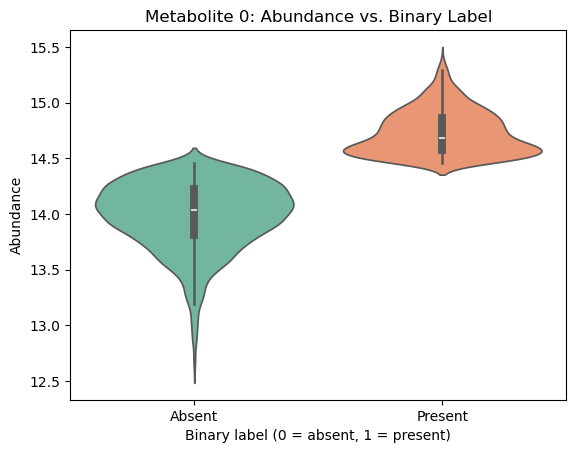

/tmp/ipykernel_1682671/2856183221.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="binary", y="abundance", inner="box", palette="Set2")


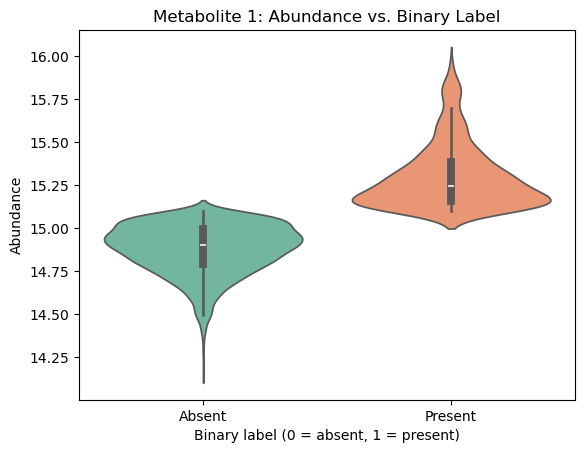

/tmp/ipykernel_1682671/2856183221.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="binary", y="abundance", inner="box", palette="Set2")


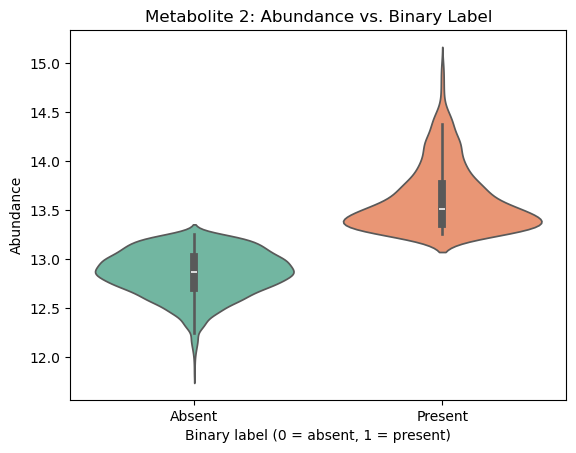

In [71]:
plot_binarization(adata_msi, metabolite_indices=[0, 1, 2])


In [72]:
from scipy.stats import skew

def get_binarization_summary(adata, layer="binary"):
    data = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
    binary = adata.layers[layer]

    summary = pd.DataFrame({
        "mean_abundance": data.mean(axis=0),
        "std_abundance": data.std(axis=0),
        "present_ratio": binary.mean(axis=0),
        "skew_abundance": skew(data, axis=0)
    })

    summary["metabolite_idx"] = summary.index
    return summary


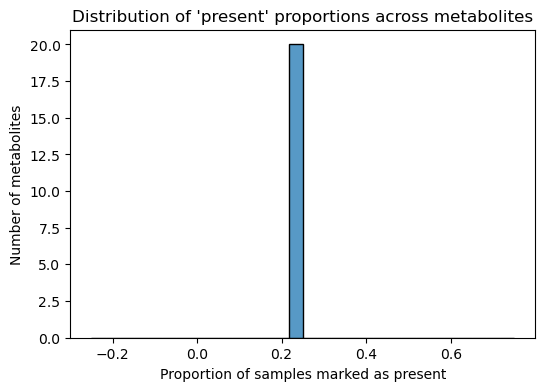

In [ ]:
summary = get_binarization_summary(adata_msi)

plt.figure(figsize=(6,4))
sns.histplot(summary["present_ratio"], bins=30)
plt.title("Distribution of 'present' proportions across metabolites")
plt.xlabel("Proportion of samples marked as present")
plt.ylabel("Number of metabolites")
plt.show()


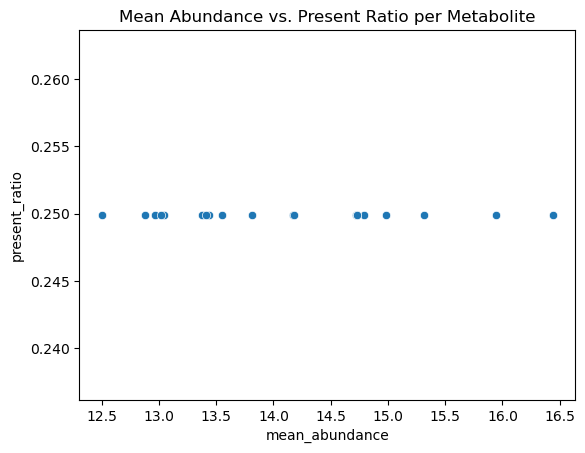

In [74]:
sns.scatterplot(data=summary, x="mean_abundance", y="present_ratio")
plt.title("Mean Abundance vs. Present Ratio per Metabolite")
plt.show()


In [75]:
adata_msi

AnnData object with n_obs × n_vars = 2681 × 20
    obs: 'technology', 'clusters', 'split', 'og_index'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'binary'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

### Set up logistic regression

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report


In [78]:
# Rerun in case you want to change the cutoff values
binarize_by_percentile(adata_msi, percentile=75)

In [79]:
adata_msi.layers["binary"].shape

(2681, 20)

split train test

In [80]:
adata_msi_train = adata_msi[adata_msi.obs["split"] == "train"]
adata_msi_test = adata_msi[adata_msi.obs["split"] == "test"]

adata_rna_train = adata_rna[adata_rna.obs["split"] == "train"]
adata_rna_test = adata_rna[adata_rna.obs["split"] == "test"]

X_train = adata_rna_train.X
X_test = adata_rna_test.X
Y_train = adata_msi_train.layers["binary"]
Y_test = adata_msi_test.layers["binary"]


Run basic classifier

In [81]:
# Create the classifier (one LR per metabolite)
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
clf.fit(X_train, Y_train)

# Predict on test set
Y_pred = clf.predict(X_test)
Y_prob = clf.predict_proba(X_test)


In [82]:
# Compute metrics per metabolite
results = []

for i in range(Y_test.shape[1]):
    y_true = Y_test[:, i]
    y_pred = Y_pred[:, i]
    y_prob = Y_prob[:, i]

    # Skip if only one class in y_true (can't compute AUC)
    if len(np.unique(y_true)) < 2:
        continue

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    results.append({
        "metabolite_idx": i,
        "accuracy": acc,
        "f1_score": f1,
        "roc_auc": auc
    })

results_df = pd.DataFrame(results)
# results_df.to_csv("/lustre/groups/ml01/workspace/eirini/bal_logreg_metrics.tsv", sep="\t", index=False)


Since we run seperate lgoregs on many mets, we need to summurize outcomes F1, ROC AUC scores

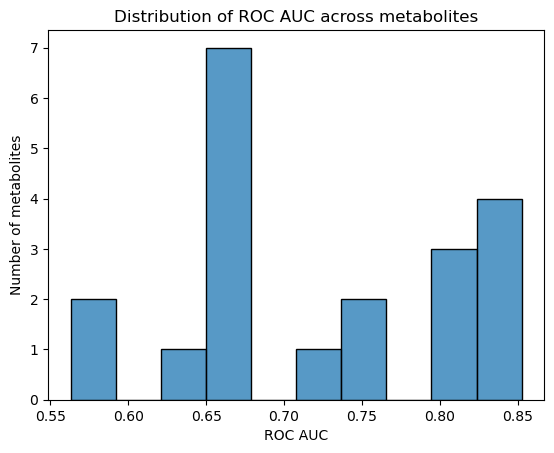

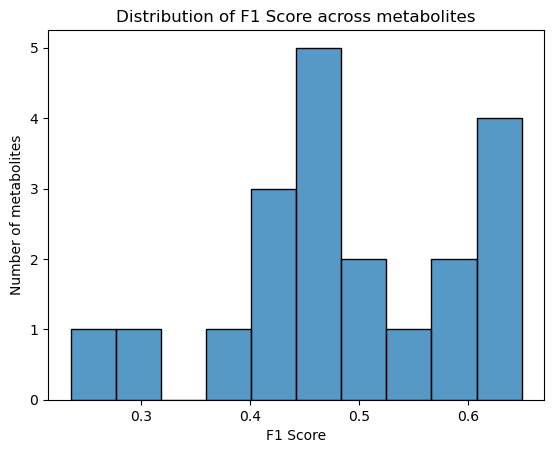

In [85]:
sns.histplot(results_df["roc_auc"], bins=10)
plt.title("Distribution of ROC AUC across metabolites")
plt.xlabel("ROC AUC")
plt.ylabel("Number of metabolites")
plt.show()
sns.histplot(results_df["f1_score"], bins=10)
plt.title("Distribution of F1 Score across metabolites")
plt.xlabel("F1 Score")
plt.ylabel("Number of metabolites")
plt.show()


Let's use balance to the classes

In [ ]:
# Rerun in case you want to change the cutoff values
binarize_by_percentile(adata_msi, percentile=50)
adata_msi.layers["binary"].shape
adata_msi_train = adata_msi[adata_msi.obs["split"] == "train"]
adata_msi_test = adata_msi[adata_msi.obs["split"] == "test"]

adata_rna_train = adata_rna[adata_rna.obs["split"] == "train"]
adata_rna_test = adata_rna[adata_rna.obs["split"] == "test"]

X_train = adata_rna_train.X
X_test = adata_rna_test.X
Y_train = adata_msi_train.layers["binary"]
Y_test = adata_msi_test.layers["binary"]


In [86]:
results_df

,metabolite_idx,accuracy,f1_score,roc_auc
0,0,0.811918,0.624535,0.847100
1,1,0.707635,0.464164,0.667896
2,2,0.722533,0.477193,0.669929
3,3,0.722533,0.465950,0.675572
4,4,0.823091,0.649446,0.852453
5,5,0.798883,0.584615,0.826913
6,6,0.763501,0.445415,0.759804
7,7,0.793296,0.596364,0.804383
8,8,0.815642,0.626415,0.816203
9,9,0.817505,0.628788,0.839737


In [ ]:
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
